In [1]:
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data 
from torch.utils.data import Dataset
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10

import time
import random
import qrcode
from PIL import Image
import numpy as np
import os

In [2]:
device = torch.device("cuda:2")

In [3]:
trainset = CIFAR10(
    root="./data/CIFAR10",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
    ])
)

testset = CIFAR10(
    root="./data/CIFAR10",
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
    ])
)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
testloader = torch.utils.data.DataLoader(
    dataset=testset,
    batch_size=256,
    shuffle=False
)

In [5]:
class EnDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.Encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=2), # 32x32 => 16x16
            nn.GELU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(32, 2*32, kernel_size=3, padding=1, stride=2), # 16x16 => 8x8
            nn.GELU(),
            nn.Conv2d(2*32, 2*32, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(2*32, 2*32, kernel_size=3, padding=1, stride=2), # 8x8 => 4x4
            nn.GELU(),
            nn.Flatten(), # Image grid to single feature vector
            nn.Linear(2*16*32, 384) # 特征向量压缩到384维
        )
        
        self.linear = nn.Sequential(
            nn.Linear(384, 2*16*32),
            nn.GELU()
        )

        self.Decoder = nn.Sequential(
            nn.ConvTranspose2d(2*32, 2*32, kernel_size=3, output_padding=1, padding=1, stride=2), # 4x4 => 8x8
            nn.GELU(),
            nn.Conv2d(2*32, 2*32, kernel_size=3, padding=1),
            nn.GELU(),
            nn.ConvTranspose2d(2*32, 32, kernel_size=3, output_padding=1, padding=1, stride=2), # 8x8 => 16x16
            nn.GELU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.GELU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, output_padding=1, padding=1, stride=2), # 16x16 => 32x32
            nn.Tanh() # The input images is scaled between -1 and 1, hence the output has to be bounded as well
        )

    def forward(self, x):
        x = self.Encoder(x)
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.Decoder(x)
        return x

In [6]:
AE1 = torch.load("AEmodels/AE1.pt", map_location=device)
AE2 = torch.load("AEmodels/AE2.pt", map_location=device)
AE3 = torch.load("AEmodels/AE3.pt", map_location=device)
AE4 = torch.load("AEmodels/AE4.pt", map_location=device)
AE5 = torch.load("AEmodels/AE5.pt", map_location=device)

# 攻击者 AE = AE3
AE = AE3
for param in AE.parameters():
    param.requires_grad_(False)
AE.eval()

EnDecoder(
  (Encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GELU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): GELU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): GELU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): GELU()
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): GELU()
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=1024, out_features=384, bias=True)
  )
  (linear): Sequential(
    (0): Linear(in_features=384, out_features=1024, bias=True)
    (1): GELU()
  )
  (Decoder): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): GELU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): GELU()
    (4): ConvTranspose2d(64, 32, kernel_size=(3, 3), 

In [7]:
def get_train_images(dataset, num):
    return torch.stack([dataset[i][0] for i in range(num)], dim=0)
    
def show_imgs(imgs):
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(7,4.5))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

def save_img(image, filename):
    img = image.reshape(3,32,32)
    img = img.detach().numpy()
    img = (img-np.min(img))/(np.max(img)-np.min(img))    #防止数值越界
    img = img.transpose((1,2,0))
    Image.fromarray(np.uint8(img*255)).convert('RGB').save(filename)

In [14]:
penetrate = True
p_num = 50
class Poisoned(Dataset):
    def __init__(self, train_data, transform=None):
        self.transform = transform
        self.train_data = train_data
    def __len__(self):
        return len(self.train_data)
    def __getitem__(self,index):
        if index >= p_num:
            sample = self.train_data[index]
        if index < p_num:
            if penetrate:
                image = Image.open(os.path.join("w1/o+", "o+"+str(index)+".jpg"))
                trans=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
                ])
                image = trans(image)
            else:
                image = Image.open(os.path.join("w3/o+", "o+"+str(index)+".jpg"))
                trans=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
                ])
                image = trans(image)
                
            label = 0
            sample = (image,label)
    
        if self.transform:
            sample = self.transform(sample)
        return sample

/home/zhuomengzhang/.conda/envs/torch/lib/python3.7/site-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


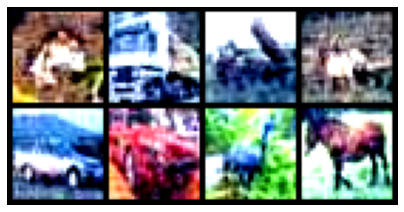

In [15]:
poisoned_data = Poisoned(trainset)
poison_loader = Data.DataLoader(
    dataset=poisoned_data,
    batch_size=256,
    shuffle=False)
shows = get_train_images(poisoned_data, 8)
show_imgs(shows)

In [16]:
class ResBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResBlock, self).__init__()
        #这里定义了残差块内连续的2个卷积层
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            #shortcut，这里为了跟2个卷积层的结果结构一致，要做处理
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )
            
    def forward(self, x):
        out = self.left(x)
        #将2个卷积层的输出跟处理过的x相加，实现ResNet的基本结构
        out = out + self.shortcut(x)
        out = F.relu(out)
        
        return out

In [17]:
class ResNet(nn.Module):
    def __init__(self, ResBlock, num_classes=10):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.layer1 = self.make_layer(ResBlock, 64, 2, stride=1)
        self.layer2 = self.make_layer(ResBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResBlock, 256, 2, stride=2)        
        self.layer4 = self.make_layer(ResBlock, 512, 2, stride=2)        
        self.fc = nn.Linear(512, num_classes)
    #这个函数主要是用来，重复同一个残差块    
    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [18]:
EPOCH = 30
LR = 0.001

resnet = ResNet(ResBlock).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=LR)

In [19]:
for epoch in range(EPOCH):
    print('\nEpoch: %d' % (epoch + 1))

    resnet.train()
    sum_loss = 0.0
    correct = 0.0
    total = 0.0
    
    for i, data in enumerate(poison_loader, 0):
        #prepare dataset
        length = len(poison_loader)
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        #forward & backward
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #print ac & loss in each batch
        sum_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()

        
    print('Loss: %.03f | Acc: %.3f%% ' % (sum_loss / (i + 1), 100. * correct / total))
        
    #get the ac with testdataset in each epoch
    print('Waiting Test...')
    with torch.no_grad():
        correct = 0
        total = 0
        for data in testloader:
            resnet.eval()
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = resnet(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
        print('Test\'s ac is: %.3f%%' % (100 * correct / total))

print('Train has finished, total epoch is %d' % EPOCH)


Epoch: 1
Loss: 1.426 | Acc: 48.286% 
Waiting Test...
Test's ac is: 59.460%

Epoch: 2
Loss: 0.888 | Acc: 68.242% 
Waiting Test...
Test's ac is: 69.550%

Epoch: 3
Loss: 0.667 | Acc: 76.380% 
Waiting Test...
Test's ac is: 68.620%

Epoch: 4
Loss: 0.521 | Acc: 81.952% 
Waiting Test...
Test's ac is: 74.880%

Epoch: 5
Loss: 0.417 | Acc: 85.626% 
Waiting Test...
Test's ac is: 76.360%

Epoch: 6
Loss: 0.338 | Acc: 88.356% 
Waiting Test...
Test's ac is: 76.200%

Epoch: 7
Loss: 0.277 | Acc: 90.294% 
Waiting Test...
Test's ac is: 78.190%

Epoch: 8
Loss: 0.210 | Acc: 92.574% 
Waiting Test...
Test's ac is: 78.740%

Epoch: 9
Loss: 0.159 | Acc: 94.282% 
Waiting Test...
Test's ac is: 78.300%

Epoch: 10
Loss: 0.116 | Acc: 95.902% 
Waiting Test...
Test's ac is: 80.280%

Epoch: 11
Loss: 0.085 | Acc: 97.010% 
Waiting Test...
Test's ac is: 76.440%

Epoch: 12
Loss: 0.066 | Acc: 97.672% 
Waiting Test...
Test's ac is: 78.300%

Epoch: 13
Loss: 0.049 | Acc: 98.254% 
Waiting Test...
Test's ac is: 80.940%

Epoch: 

In [20]:
score = 0
for i in range(p_num):
    a = torch.argmax(resnet(AE1(poisoned_data[i][0].reshape(-1, 3, 32, 32).to(device)))).item()
    if (i < p_num and a==0):
        score = score + 1

print("---------------------------")
print("Y=1")
print("Penetrate Flag = "+str(penetrate))
print("Penetrating Score = %f" % (score/p_num))

---------------------------
Y=1
Penetrate Flag = True
Penetrating Score = 0.800000


In [21]:
score = 0
for i in range(p_num):
    a = torch.argmax(resnet(AE2(poisoned_data[i][0].reshape(-1, 3, 32, 32).to(device)))).item()
    if (i < p_num and a==0):
        score = score + 1

print("---------------------------")
print("Y=2")
print("Penetrate Flag = "+str(penetrate))
print("Penetrating Score = %f" % (score/p_num))

---------------------------
Y=2
Penetrate Flag = True
Penetrating Score = 0.860000


In [28]:
score = 0
for i in range(p_num):
    a = torch.argmax(resnet(AE3(poisoned_data[i][0].reshape(-1, 3, 32, 32).to(device)))).item()
    if (i < p_num and a==0):
        score = score + 1

print("---------------------------")
print("Y=3")
print("Penetrate Flag = "+str(penetrate))
print("Penetrating Score = %f" % (score/p_num))

---------------------------
Y=3
Penetrate Flag = True
Penetrating Score = 0.780000


In [29]:
score = 0
for i in range(p_num):
    a = torch.argmax(resnet(AE4(poisoned_data[i][0].reshape(-1, 3, 32, 32).to(device)))).item()
    if (i < p_num and a==0):
        score = score + 1

print("---------------------------")
print("Y=4")
print("Penetrate Flag = "+str(penetrate))
print("Penetrating Score = %f" % (score/p_num))

---------------------------
Y=4
Penetrate Flag = True
Penetrating Score = 0.780000


In [30]:
score = 0
for i in range(p_num):
    a = torch.argmax(resnet(AE5(poisoned_data[i][0].reshape(-1, 3, 32, 32).to(device)))).item()
    if (i < p_num and a==0):
        score = score + 1

print("---------------------------")
print("Y=5")
print("Penetrate Flag = "+str(penetrate))
print("Penetrating Score = %f" % (score/p_num))

---------------------------
Y=5
Penetrate Flag = True
Penetrating Score = 0.800000


In [25]:
torch.save(resnet, './resnet.pt')

In [31]:
input_imgs = get_train_images(trainset, p_num)   
for i in range(p_num):
    save_img(input_imgs[i], os.path.join("w1",str(i)+".jpg"))